In [1]:
import torch
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("GPU")
else:
  device = torch.device("cpu")
  print("CPU")

GPU


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from zipfile import *
file_name = "/content/drive/MyDrive/D30_750/dataset_20_classes.zip" 
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [4]:
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision
import pathlib
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import math

In [5]:
batch_size = 64

In [6]:
data_transforms = transforms.Compose([
    transforms.ToTensor()
])

In [7]:
path = "./dataset_20_classes"
dataset = datasets.ImageFolder(root=path,transform = data_transforms)
data_loader = torch.utils.data.DataLoader(dataset = dataset,batch_size=batch_size,shuffle=False)

In [8]:
root=pathlib.Path(path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes)

['Apple_healthy', 'Apple_unhealthy', 'Cherry_healthy', 'Cherry_unhealthy', 'Grape_healthy', 'Grape_unhealthy', 'Mango_healthy', 'Mango_unhealthy', 'Peach_healthy', 'Peach_unhealthy', 'Pepperbell_healthy', 'Pepperbell_unhealthy', 'Pomegranate_healthy', 'Pomegranate_unhealthy', 'Potato_healthy', 'Potato_unhealthy', 'Strawberry_healthy', 'Strawberry_unhealthy', 'Tomato_healthy', 'Tomato_unhealthy']


In [ ]:
def get_mean_and_std(loader):
    mean = 0.
    std = 0.
    batch = 1
    total_images_count = 0
    for images, _ in loader:
        print("Mean and Std for Batch "+str(batch))
        batch = batch+1
        image_count_in_a_batch = images.size(0)
        images = images.view(image_count_in_a_batch,images.size(1),-1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += image_count_in_a_batch
    mean /= total_images_count
    std /= total_images_count
    return mean,std
mean,std = get_mean_and_std(data_loader)

In [10]:
data_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))
])

In [11]:
dataset = torchvision.datasets.ImageFolder(root = path,transform = data_transforms)

labels tensor([19,  7, 14,  6, 19, 15])


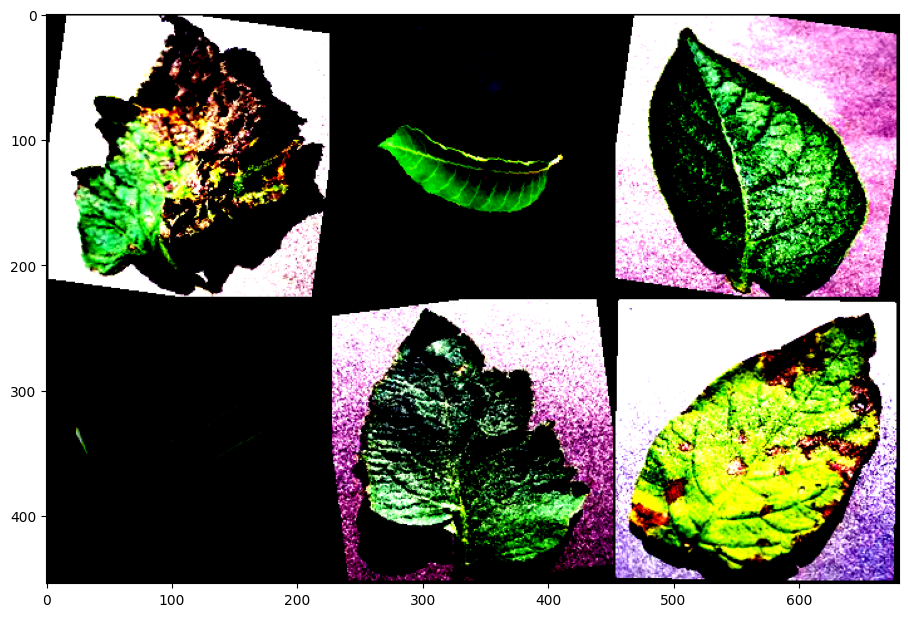

In [12]:
def show_transformed_images(dataset):
    loader = torch.utils.data.DataLoader(dataset,batch_size = 6,shuffle=True)
    batch = next(iter(loader))
    images,labels = batch
    
    grid = torchvision.utils.make_grid(images,nrow = 3)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid,(1,2,0)))
    print('labels',labels)
show_transformed_images(dataset)

In [13]:
train_size = int(0.7 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset)-train_size-val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size,test_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, drop_last=False, num_workers=0)
val_loader   = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=0)
print(str(train_size)+" "+str(val_size)+" "+str(test_size))

13803 1971 3945


In [15]:
model = models.resnet18(pretrained=False, num_classes=20)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
optimizer=torch.optim.SGD(model.parameters(), lr=0.001,momentum=0.9)
loss_function=nn.CrossEntropyLoss()
num_epochs=50
batch_size = batch_size

In [17]:
train_count = len(train_dataset)
test_count = len(test_dataset)
val_count = len(val_dataset)

In [18]:
#Model training and saving best model

best_accuracy=0.0
train_accu_l = []
val_accu_l = []
val_loss_l = []
train_loss_l = []
batch_train_accu_l = []
batch_train_loss_l = []
for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    total_batches = math.ceil(train_count/batch_size)
    batch = 0
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
        images_count = len(images)
        batch_train_accuracy = 0
        batch_train_loss = 0
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        batch_train_loss+= int(loss.cpu().data*images.size(0))
        _,prediction=torch.max(outputs.data,1)
        
        batch_train_accuracy+=int(torch.sum(prediction==labels.data))*100
        train_accuracy+=batch_train_accuracy
        train_loss+=batch_train_loss
        batch_train_accuracy = batch_train_accuracy/images_count
        batch_train_loss = batch_train_loss/images_count
        images_count+=batch_size    
        batch = batch+1; 
        batch_train_accu_l.append(batch_train_accuracy)
        batch_train_loss_l.append(batch_train_loss)
        
        #print('Epoch: '+str(epoch+1)+" Batch:["+str(batch)+"/"+str(total_batches)+"]"+' Train Loss: '+str(batch_train_loss)+' Train Accuracy: '+str(batch_train_accuracy))

    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    
    
    # Evaluation on validation dataset
    model.eval()
    
    val_accuracy=0.0
    val_loss = 0.0
    for i, (images,labels) in enumerate(val_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
        val_loss+= int(loss.cpu().data*images.size(0))
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        val_accuracy+=int(torch.sum(prediction==labels.data))*100
    
    val_accuracy=val_accuracy/val_count
    val_loss=val_loss/val_count
    train_accu_l.append(train_accuracy)
    val_accu_l.append(val_accuracy)
    val_loss_l.append(val_loss)
    train_loss_l.append(train_loss)
    
    print('Epoch: '+str(epoch+1)+' | Training Loss: '+str(round(train_loss,4))+' | Training Accuracy: '+str(round(train_accuracy,2))+"% "+' | Validation Loss: '+str(round(val_loss,4))+' | Validation Accuracy: '+str(round(val_accuracy,2))+"%")
    
    #Save the best model
    if val_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint.model')
        best_accuracy=val_accuracy

Epoch: 1 | Training Loss: 1.855 | Training Accuracy: 43.64%  | Validation Loss: 1.2187 | Validation Accuracy: 58.9%
Epoch: 2 | Training Loss: 0.9709 | Training Accuracy: 69.34%  | Validation Loss: 0.9528 | Validation Accuracy: 73.82%
Epoch: 3 | Training Loss: 0.6578 | Training Accuracy: 78.8%  | Validation Loss: 0.3907 | Validation Accuracy: 80.57%
Epoch: 4 | Training Loss: 0.4784 | Training Accuracy: 84.81%  | Validation Loss: 0.5155 | Validation Accuracy: 85.49%
Epoch: 5 | Training Loss: 0.3504 | Training Accuracy: 89.1%  | Validation Loss: 0.4997 | Validation Accuracy: 80.47%
Epoch: 6 | Training Loss: 0.2744 | Training Accuracy: 91.41%  | Validation Loss: 0.2187 | Validation Accuracy: 81.99%
Epoch: 7 | Training Loss: 0.2251 | Training Accuracy: 93.15%  | Validation Loss: 0.4531 | Validation Accuracy: 92.54%
Epoch: 8 | Training Loss: 0.1887 | Training Accuracy: 93.69%  | Validation Loss: 0.2344 | Validation Accuracy: 93.15%
Epoch: 9 | Training Loss: 0.1707 | Training Accuracy: 94.44%

In [19]:
y_true = []
y_pred = []
model.eval()
test_accuracy=0.0
for i, (images,labels) in enumerate(test_loader):
    if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
    outputs=model(images)
    _,prediction=torch.max(outputs.data,1)
    test_accuracy+=int(torch.sum(prediction==labels.data))*100
    y_true.extend(labels.data.cpu().numpy())
    y_pred.extend(prediction.data.cpu().numpy())
final_test_accuracy = test_accuracy/test_count
print("Accuracy on Test Data with "+str(test_count)+" images is "+str(round(final_test_accuracy,2))+"%")

Accuracy on Test Data with 3945 images is 97.82%


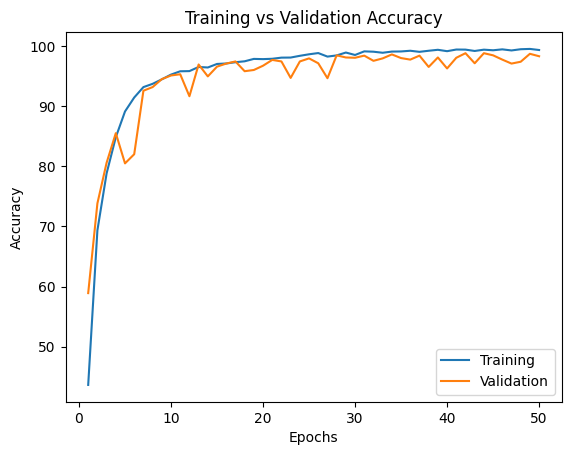

In [33]:
plt.plot(range(1,num_epochs+1),train_accu_l,label="Training")
plt.plot(range(1,num_epochs+1),val_accu_l, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()

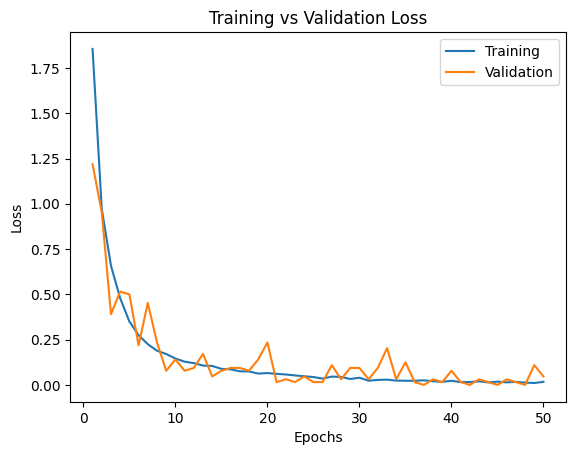

In [35]:
plt.plot(range(1,num_epochs+1),train_loss_l,label="Training")
plt.plot(range(1,num_epochs+1),val_loss_l, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

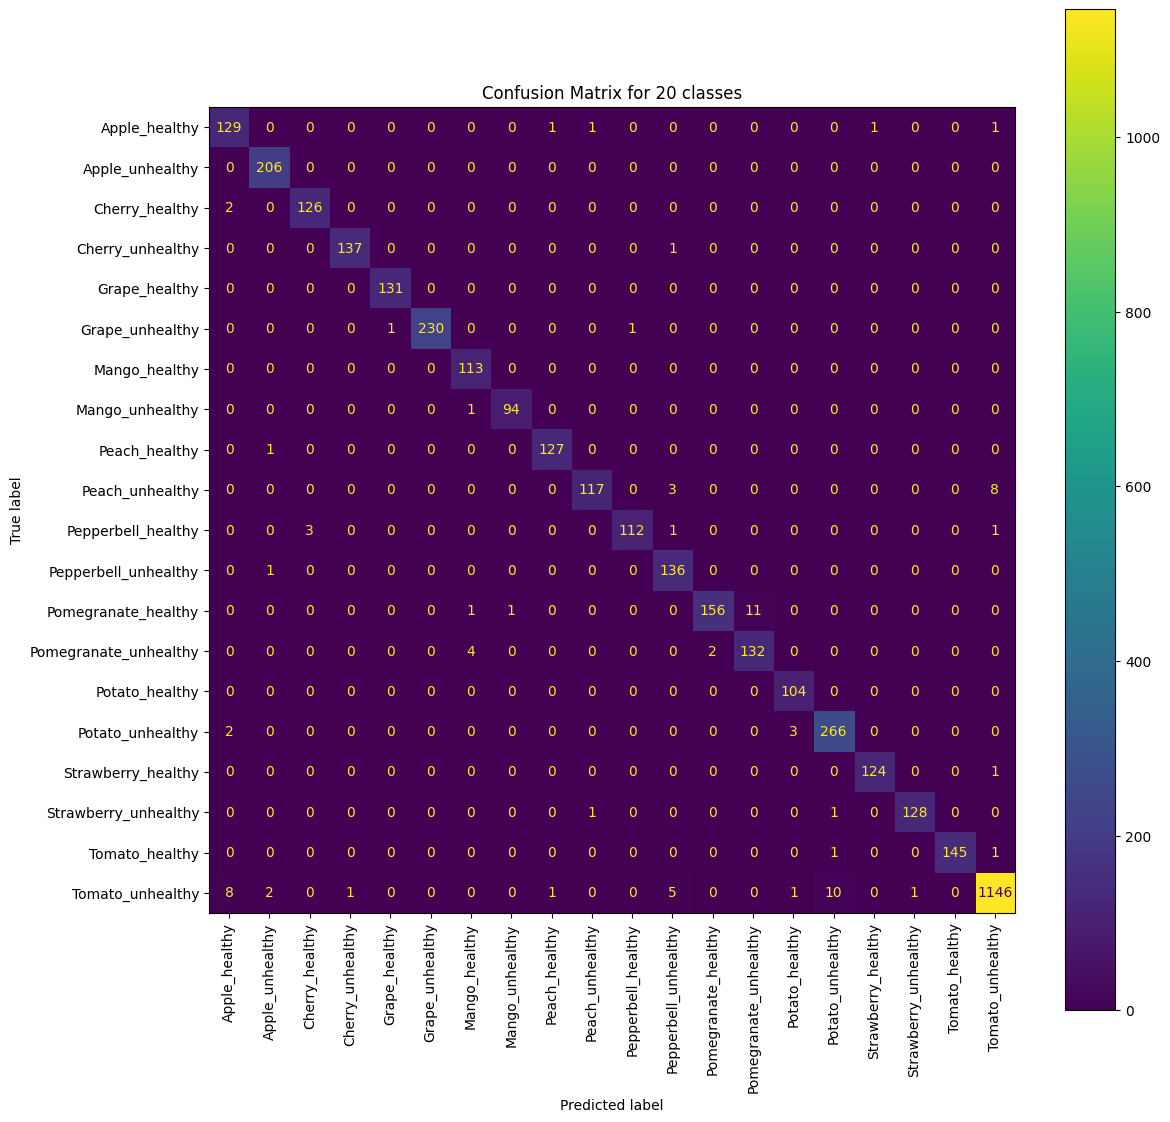

In [39]:
confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred),display_labels=classes)
fig,ax = plt.subplots()
fig.set_size_inches(13,13)
plt.title("Confusion Matrix for 20 classes")
disp.plot(ax=ax)
plt.xticks(rotation=90)
plt.show()

In [40]:
print("Accuracy on Test Data :"+str(final_test_accuracy)+"%")
print("Precision on Test Data :{:.2f}".format(precision_score(y_true,y_pred,average='micro')))
print("Recall on Test Data :{:.2f}".format(recall_score(y_true,y_pred,average='micro')))
print("F1-Score on Test Data :{:.2f}".format(f1_score(y_true,y_pred,average='micro')))

Accuracy on Test Data :97.82002534854246%
Precision on Test Data :0.98
Recall on Test Data :0.98
F1-Score on Test Data :0.98


In [42]:
import pandas
df = pandas.DataFrame(data={"Epochs": list(range(1,num_epochs+1)), "Training Accuracy": train_accu_l,"Validation Accuracy": val_accu_l})
df.to_csv("./accuracies_D3_ResNet_18.csv", sep=',',index=False)
df = pandas.DataFrame(data={"Epochs": list(range(1,num_epochs+1)), "Training Loss": train_loss_l,"Validation Loss": val_loss_l})
df.to_csv("./loss_D3_ResNet_18.csv", sep=',',index=False)
df = pandas.DataFrame(data={"Y_true": y_true, "Y_pred": y_pred})
df.to_csv("./Y_values_D3_ResNet_18.csv", sep=',',index=False)